In [1]:
using FileIO, Statistics
using Images
using Flux
using MLDataUtils: splitobs, shuffleobs

function preprocess_image(file_path)
    img = load(file_path)  # Load the image using FileIO
    img_resized = imresize(img, (64, 64))  # Resize image to 64x64
    img_float = Float32.(channelview(img_resized)) ./ Float32(255.0)  # Normalize pixel values
    # return img_float
    if size(img_float, 1) != 3
        return nothing
    end
    try
        img_permuted = permutedims(img_float, (2, 3, 1))  # Permute dimensions to (Channels, Height, Width)
        return img_permuted
    catch ArgumentError
        return nothing
    end
end

# Function to load the dataset
function load_dataset(dataset_dir)
    images, labels = [], []
    classes = readdir(dataset_dir)

    # Assign a numeric label to each class
    class_to_index = Dict(class_name => i for (i, class_name) in enumerate(classes))
    
    for class in classes
        class_dir = joinpath(dataset_dir, class)
        for image_file in readdir(class_dir)
            full_path = joinpath(class_dir, image_file)
            preprocessed_image = preprocess_image(full_path)
            if preprocessed_image != nothing
                push!(images, preprocessed_image)
                push!(labels, class_to_index[class])
            end
        end
    end

    # Convert labels to one-hot encoding
    labels = Flux.onehotbatch(labels, 1:length(classes))

    # Split dataset into training, validation, and test sets
    return splitobs(shuffleobs((images, labels)), at = 0.7)
end

load_dataset (generic function with 1 method)

In [2]:
classes = readdir("dataset2")
train_data, test_data = load_dataset("dataset2")

x, y = train_data
trainData = []
for i in range(start=1, stop=size(x, 1), step=1)
    push!(trainData, (Flux.unsqueeze(x[i], 4), y[:, i]))
end

x, y = test_data
testData = []
for i in range(start=1, stop=size(x, 1), step=1)
    push!(testData, (Flux.unsqueeze(x[i], 4), y[:, i]))
end

┌ Warning: Premature end of JPEG byte sequence.
└ @ JpegTurbo /Users/advaitshukla/.julia/packages/JpegTurbo/qyyJK/src/decode.jl:220
┌ Warning: Premature end of JPEG byte sequence.
└ @ JpegTurbo /Users/advaitshukla/.julia/packages/JpegTurbo/qyyJK/src/decode.jl:220


┌ Warning: Premature end of JPEG byte sequence.
└ @ JpegTurbo /Users/advaitshukla/.julia/packages/JpegTurbo/qyyJK/src/decode.jl:220
┌ Warning: Premature end of JPEG byte sequence.
└ @ JpegTurbo /Users/advaitshukla/.julia/packages/JpegTurbo/qyyJK/src/decode.jl:220


In [45]:
model_cnn = Chain(
    Conv((3, 3), 3=>8, relu, pad=(1,1)),  
    MaxPool((2, 2)),                       
    Conv((3, 3), 8=>16, relu, pad=(1,1)),  
    MaxPool((2, 2)),                       
    Flux.flatten,
    Dense(16 * 16 * 16, 120),              
    Dense(120, 84),
    Dense(84, 4),                         
    Flux.softmax
)

encoder = Chain(
    Conv((3, 3), 3=>8, relu, pad=(1,1)),  
    MaxPool((2, 2)), 
    Flux.flatten,
    Dense(32*32*8 => 32, relu),
)

decoder = Chain(
    Dense(32 => 32*32*8, relu),
    x -> reshape(x, 32, 32, 8, :),  
    Upsample(scale=(2,2)),  
    Conv((3, 3), 8=>3, relu, pad=(1,1)), 
    x -> sigmoid.(x)  
)

classifier = Chain(
    Dense(32 => 16, relu),
    Dense(16 => 4, relu),
    Flux.softmax
)

encoder_classifier = Chain(encoder, classifier)

autoencoder = Chain(encoder, decoder)


Chain(
  Chain(
    Conv((3, 3), 3 => 8, relu, pad=1),  # 224 parameters
    MaxPool((2, 2)),
    Flux.flatten,
    Dense(8192 => 32, relu),            # 262_176 parameters
  ),
  Chain(
    Dense(32 => 8192, relu),            # 270_336 parameters
    var"#47#49"(),
    Upsample(:nearest, scale = (2, 2)),
    Conv((3, 3), 8 => 3, relu, pad=1),  # 219 parameters
    var"#48#50"(),
  ),
)                   # Total: 8 arrays, 532_955 parameters, 2.035 MiB.

In [4]:
function getAccuracy(model, data)
    correct = 0
    for i in 1:size(data, 1)
        pred = zeros(4)
        predlabel = argmax(model(data[i][1]))
        pred[predlabel] = 1
        if pred == data[i][2]
            correct += 1
        end
    end
    return correct / size(data, 1)
end
# getAccuracy(model_cnn, testData)

getAccuracy (generic function with 1 method)

In [5]:
loss(x, y) = Flux.crossentropy(model_cnn(x), y)
optimizer = ADAM()
epochs = 50
trainLosses = []
testLosses = []
accuracies = []
for epoch in 1:epochs
    Flux.train!(loss, Flux.params(model_cnn), trainData, optimizer)
    accuracy = getAccuracy(model_cnn, testData)
    push!(trainLosses, mean([loss(x, y) for (x, y) in trainData]))
    push!(testLosses, mean([loss(x, y) for (x, y) in testData]))
    push!(accuracies, accuracy)
    @info "Epoch $epoch done"
end

┌ Info: Epoch 1 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 2 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 3 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 4 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 5 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 6 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 7 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 8 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 9 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 10 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 11 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 12 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 13 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 14 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 15 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 16 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 17 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 18 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 19 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 20 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 21 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 22 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 23 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 24 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 25 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 26 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 27 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 28 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 29 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 30 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 31 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 32 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 33 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 34 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 35 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 36 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 37 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 38 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 39 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 40 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 41 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 42 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 43 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 44 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 45 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 46 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 47 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 48 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 49 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 50 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


In [40]:
l = Flux.params(model_cnn)

prod(collect(size(l[1])))
0:5

0:5

In [42]:
p = Flux.params(model_cnn)
numParams = 0
for layer in p
    numParams += prod(collect(size(layer)))
end

plot(0:log10(numParams*epochs), trainLosses, xlabel="log (wt updates)", ylabel="Loss", label="Train Loss", title="CNN without autoencoder")
plot!(0:log10(numParams*epochs), testLosses, label="Test Loss")

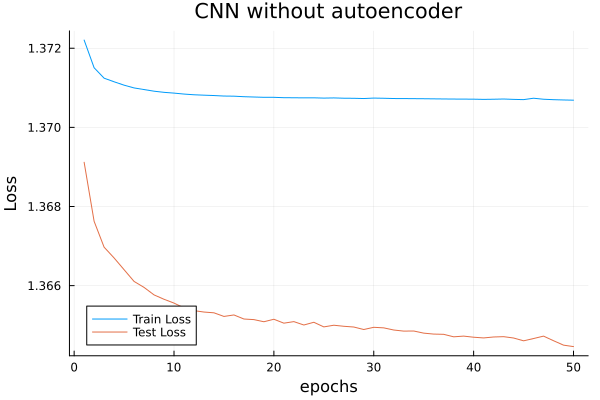

In [43]:
using Plots
plot(1:epochs, trainLosses, xlabel="epochs", ylabel="Loss", label="Train Loss", title="CNN without autoencoder")
plot!(1:epochs, testLosses, label="Test Loss")

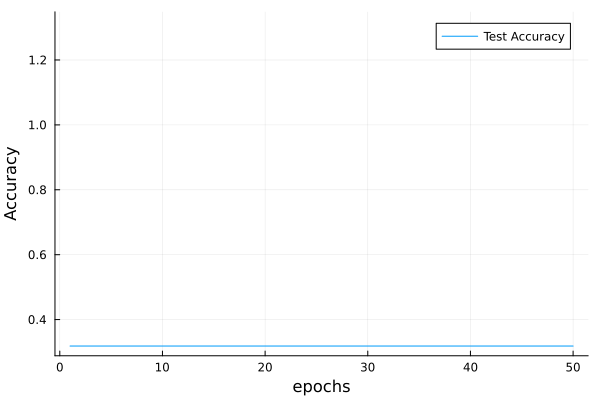

In [7]:
plot(1:epochs, accuracies, xlabel="epochs", ylabel="Accuracy", label = "Test Accuracy")

In [49]:
println("Accuracies: $(accuracies[end]*100)%")

Accuracies: 31.845238095238095%


In [9]:
x, y = train_data
trainDataAE = []
for i in range(start=1, stop=size(x, 1), step=1)
    push!(trainDataAE, (reshape(Flux.flatten(x[i]), 4096*3), y[:, i]))
end

x, y = test_data
testDataAE = []
for i in range(start=1, stop=size(x, 1), step=1)
    push!(testDataAE, (reshape(Flux.flatten(x[i]), 4096*3), y[:, i]))
end

In [12]:
aeLoss(x, y) = Flux.mse(autoencoder(x), x)
optimizer = ADAM()
epochs = 50
trainLossesAE = []
testLossesAE = []
for epoch in 1:epochs
    Flux.train!(aeLoss, Flux.params(autoencoder), trainData, optimizer)
    push!(trainLossesAE, mean([aeLoss(x, y) for (x, y) in trainData]))
    push!(testLossesAE, mean([aeLoss(x, y) for (x, y) in testData]))
    @info "Epoch $epoch done"
end

┌ Info: Epoch 1 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 2 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 3 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 4 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 5 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 6 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 7 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 8 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 9 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 10 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 11 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 12 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 13 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 14 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 15 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 16 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 17 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 18 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 19 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 20 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 21 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 22 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 23 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 24 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 25 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 26 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 27 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 28 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 29 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 30 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 31 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 32 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 33 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 34 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 35 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 36 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 37 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 38 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 39 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 40 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 41 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 42 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 43 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 44 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 45 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 46 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 47 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 48 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 49 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


┌ Info: Epoch 50 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:10


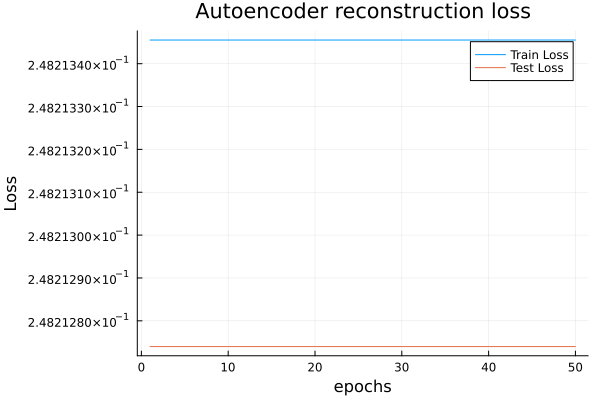

In [21]:
plot(1:epochs, trainLossesAE, xlabel="epochs", ylabel="Loss", label="Train Loss", title="Autoencoder reconstruction loss")
plot!(1:epochs, testLossesAE, label="Test Loss")

In [25]:
ecLoss(x, y) = Flux.crossentropy(encoder_classifier(x), y)
optimizer = ADAM()
epochs = 50
trainLossesEC = []
testLossesEC = []
accuraciesEC = []
for epoch in 1:epochs
    Flux.train!(ecLoss, Flux.params(encoder_classifier), trainData, optimizer)
    accuracy = getAccuracy(encoder_classifier, testData)
    push!(trainLossesEC, mean([ecLoss(x, y) for (x, y) in trainData]))
    push!(testLossesEC, mean([ecLoss(x, y) for (x, y) in testData]))
    push!(accuraciesEC, accuracy)
    @info "Epoch $epoch done"
end

┌ Info: Epoch 1 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 2 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 3 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 4 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 5 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 6 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 7 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 8 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 9 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 10 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 11 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 12 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 13 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 14 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 15 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 16 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 17 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 18 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 19 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 20 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 21 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 22 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 23 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 24 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 25 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 26 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 27 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 28 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 29 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 30 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 31 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 32 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 33 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 34 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 35 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 36 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 37 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 38 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 39 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 40 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 41 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 42 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 43 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 44 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 45 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 46 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 47 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 48 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 49 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


┌ Info: Epoch 50 done
└ @ Main /Users/advaitshukla/Documents/ANN/image2.ipynb:13


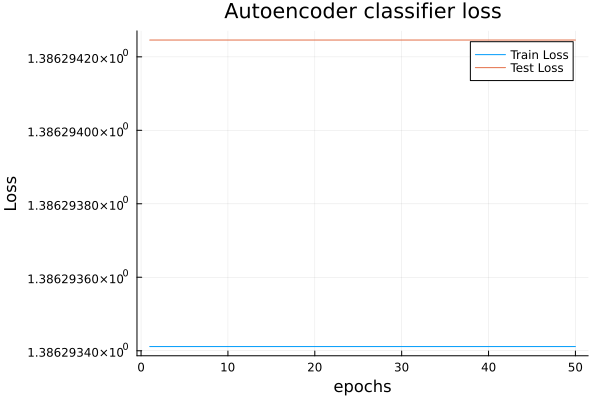

In [27]:
plot(1:epochs, trainLossesEC, xlabel="epochs", ylabel="Loss", label="Train Loss", title="Autoencoder classifier loss")
plot!(1:epochs, testLossesEC, label="Test Loss")

In [48]:
println("Accuracy: $(accuraciesEC[end]*100)%")

Accuracy: 27.976190476190478%
